In [55]:
#importing the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [56]:
#Reading the dataset and displaying the first five rows

df = pd.read_csv("Fraud Detection.csv")
df.head(5)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,isFraud
0,300,TRANSFER,890577.21,C1610053124,218.00,0.00,C2134570494,0.00,890577.21,0,0
1,399,CASH_IN,97734.24,C1159686943,2096258.84,2193993.08,C1110663773,320136.00,222401.76,0,0
2,718,PAYMENT,5907.41,C1079460540,315.00,0.00,M143445429,0.00,0.00,0,0
3,186,CASH_OUT,187696.30,C1351948367,11057.00,0.00,C1425776462,1798095.21,1985791.51,0,0
4,331,CASH_OUT,82646.52,C2112196651,0.00,0.00,C1864764190,1047805.87,1130452.39,0,0


Exploratory Data Analysis

In [57]:
#to check the shape of the dataset

df.shape

(1272524, 11)

In [58]:
#to check the null values in dataset

df.isnull().sum().sum()

np.int64(0)

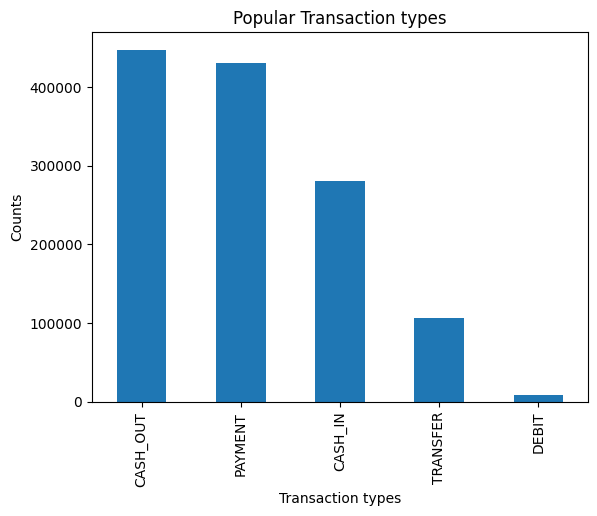

In [59]:
# to check the most popular transaction types

df["type"].value_counts().plot(kind = "bar", title = "Popular Transaction types",)
plt.xlabel("Transaction types")
plt.ylabel("Counts")
plt.show()

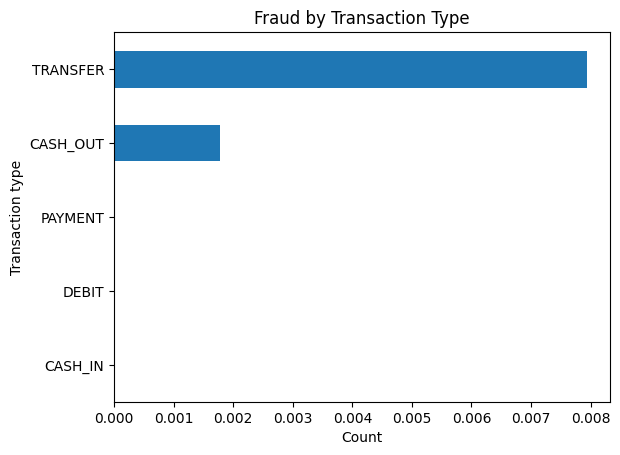

In [60]:
# to check where fraud occurs more

fraud_transactions = df.groupby("type")["isFraud"].mean().sort_values(ascending=True)
fraud_transactions.plot(kind = "barh", title = "Fraud by Transaction Type" )
plt.xlabel("Count")
plt.ylabel("Transaction type")
plt.show()

In [61]:
# to find the percentage of Fraud Transactions
fraud_transactions = df["isFraud"].value_counts()[1]/df.shape[0]
percentage_of_fraud = round(fraud_transactions * 100,2)
percentage_of_fraud

np.float64(0.13)

In [62]:
#drop unnecessary columns
df = df.drop(["step","nameOrig","nameDest","isFlaggedFraud"],axis=1)

In [63]:
#cross verify if the columnms are dropped

df.head(5)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,TRANSFER,890577.21,218.00,0.00,0.00,890577.21,0
1,CASH_IN,97734.24,2096258.84,2193993.08,320136.00,222401.76,0
2,PAYMENT,5907.41,315.00,0.00,0.00,0.00,0
3,CASH_OUT,187696.30,11057.00,0.00,1798095.21,1985791.51,0
4,CASH_OUT,82646.52,0.00,0.00,1047805.87,1130452.39,0


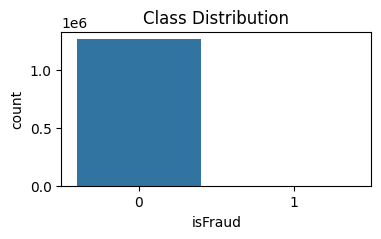

In [64]:
# to check class distribution 

plt.figure(figsize=(4,2))
sns.countplot(x="isFraud", data=df)
plt.title("Class Distribution")
plt.show()


### Since the class distribution is very imbalanced, we have to make it balanced before building the model

In [65]:
#label encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df["Type_Encoded"] = label_encoder.fit_transform(df["type"])
X = df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'Type_Encoded']]
y = df["isFraud"]

In [66]:
#splitting the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state=42)

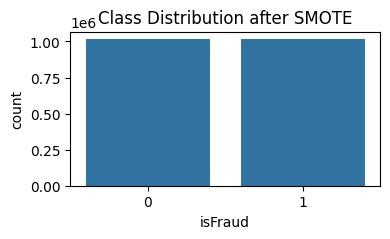

In [67]:
#resampling the data
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train,y_train)
# to check the class distribution after SMOTE
plt.figure(figsize=(4,2))
sns.countplot(x=y_resampled)
plt.title("Class Distribution after SMOTE")
plt.show()

In [68]:
#training the model
import lightgbm as lgb
from lightgbm import LGBMClassifier
lgb_model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    metrics='auc',
    learning_rate=0.05,
    num_leaves=31,
    max_depth=3,   #depth for splits
    n_estimators=200,
)
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1326, number of negative: 1016693
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 1018019, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001303 -> initscore=-6.642144
[LightGBM] [Info] Start training from score -6.642144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,3
,learning_rate,0.05
,n_estimators,200
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [69]:
y_pred = lgb_model.predict(X_test)
from sklearn.metrics import classification_report,  confusion_matrix
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    254188
           1       0.78      0.68      0.73       317

    accuracy                           1.00    254505
   macro avg       0.89      0.84      0.86    254505
weighted avg       1.00      1.00      1.00    254505

[[254126     62]
 [   101    216]]


In [70]:
lgb_model.score(X_test, y_test)

0.9993595410699201

In [71]:
import joblib

In [72]:
joblib.dump(lgb_model,"lgb_model.pkl")

['lgb_model.pkl']